*Read section 8.1.1 of the book before using these notes.*

*Note that in this course, lecture notes are not sufficient, you must read the book for better understanding. Lecture notes are just implementing the concepts of the book on a dataset, but not explaining the concepts elaborately.*

In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid

#Libraries for visualizing trees
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image  
import pydotplus
import time as tm

In [158]:
#Using the same datasets as used for linear regression in STAT303-2, 
#so that we can compare the non-linear models with linear regression
trainf = pd.read_csv('./Datasets/Car_features_train.csv')
trainp = pd.read_csv('./Datasets/Car_prices_train.csv')
testf = pd.read_csv('./Datasets/Car_features_test.csv')
testp = pd.read_csv('./Datasets/Car_prices_test.csv')
train = pd.merge(trainf,trainp)
test = pd.merge(testf,testp)
train.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,18473,bmw,6 Series,2020,Semi-Auto,11,Diesel,145,53.3282,3.0,37980
1,15064,bmw,6 Series,2019,Semi-Auto,10813,Diesel,145,53.0430,3.0,33980
2,18268,bmw,6 Series,2020,Semi-Auto,6,Diesel,145,53.4379,3.0,36850
3,18480,bmw,6 Series,2017,Semi-Auto,18895,Diesel,145,51.5140,3.0,25998
4,18492,bmw,6 Series,2015,Automatic,62953,Diesel,160,51.4903,3.0,18990


## Building a regression tree
Develop a regression tree to predict car price based on mileage

In [3]:
X = train['mileage']
y = train['price']

In [4]:
#Defining the object to build a regression tree
model = DecisionTreeRegressor(random_state=1, max_depth=3) 

#Fitting the regression tree to the data
model.fit(X.values.reshape(-1,1), y)

DecisionTreeRegressor(max_depth=3, random_state=1)

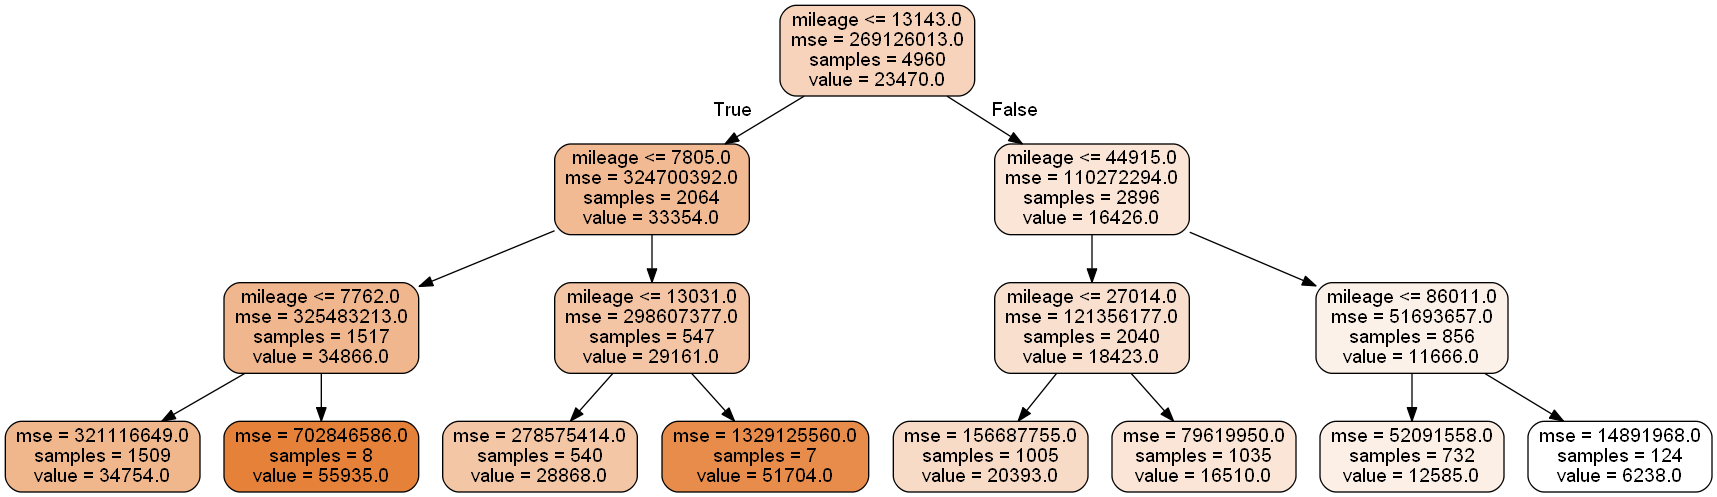

In [5]:
#Visualizing the regression tree
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                feature_names =['mileage'],precision=0)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('car_price_tree.png')
Image(graph.create_png())

In [11]:
#prediction on test data
pred=model.predict(test[['mileage']])

In [12]:
#RMSE on test data
np.sqrt(mean_squared_error(test.price, pred))

13764.798425410803

<AxesSubplot:xlabel='mileage', ylabel='price'>

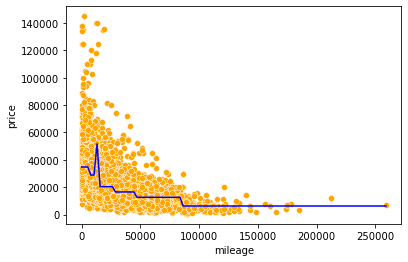

In [9]:
#Visualizing the model fit
Xtest = np.linspace(min(X), max(X), 100)
pred_test = model.predict(Xtest.reshape(-1,1))
sns.scatterplot(x = 'mileage', y = 'price', data = train, color = 'orange')
sns.lineplot(x = Xtest, y = pred_test, color = 'blue')

All cars falling within the same terminal node have the same predicted price, which is seen as flat line segments in the above model curve

**Develop a regression tree to predict car price based on `mileage`, `mpg`, `engineSize` and `year`**

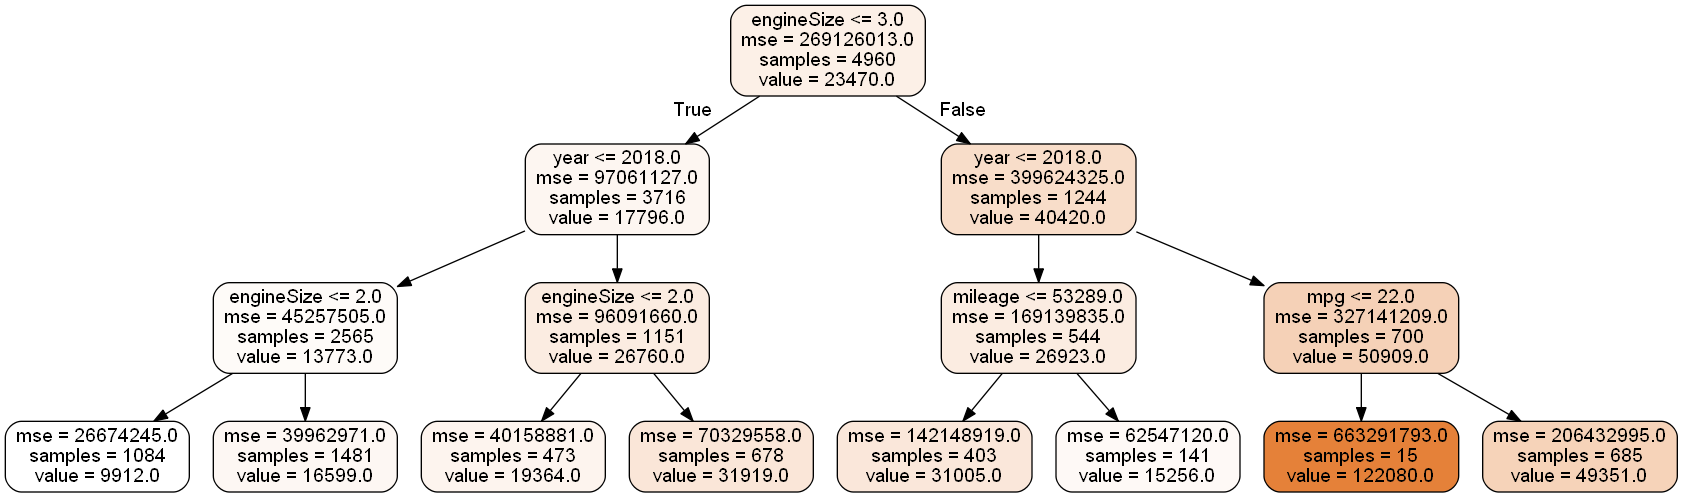

In [159]:
X = train[['mileage','mpg','year','engineSize']]
model = DecisionTreeRegressor(random_state=1, max_depth=3) 
model.fit(X, y)
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                feature_names =['mileage','mpg','year','engineSize'],precision=0)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('car_price_tree.png')
Image(graph.create_png())

## Optimizing parameters to improve the regression tree

Let us find the optimal depth of the tree and the number of terminal nods (leaves) by cross validation.

### Range of hyperparameter values

First, we'll find the minimum and maximum possible values of the depth and leaves, and then find the optimal value in that range.

In [19]:
model = DecisionTreeRegressor(random_state=1) 
model.fit(X, y)

print("Maximum tree depth =", model.get_depth())

print("Maximum leaves =", model.get_n_leaves())

Maximum tree depth = 29
Maximum leaves = 4845


### Cross validation: Coarse grid

We'll use the `sklearn` function [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to find the optimal hyperparameter values over a grid of possible values. By default, `GridSearchCV` returns the optimal hyperparameter values based on the coefficient of determination [$R^2$](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score). However, the `scoring` argument of the function can be used to find the optimal parameters based on several different criteria as mentioned in the [scoring-parameter documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

In [73]:
#Finding cross-validation error for trees 
parameters = {'max_depth':range(2,30, 3),'max_leaf_nodes':range(2,4900, 100)}
cv = KFold(n_splits = 5,shuffle=True,random_state=1)
model = GridSearchCV(DecisionTreeRegressor(random_state=1), parameters, n_jobs=-1,verbose=1,cv=cv)
model.fit(X, y)
print (model.best_score_, model.best_params_) 

Fitting 5 folds for each of 490 candidates, totalling 2450 fits
0.8433100904754441 {'max_depth': 11, 'max_leaf_nodes': 302}


Let us find the optimal hyperparameters based on the mean squared error, instead of $R^2$. Let us compute $R^2$ as well during cross validation, as we can compute multiple performance metrics using the `scoring` argument. However, when computing multiple performance metrics, we will need to specify the performance metric used to find the optimal hyperparameters with the `refit` argument.

In [92]:
#Finding cross-validation error for trees 
parameters = {'max_depth':range(2,30, 3),'max_leaf_nodes':range(2,4900, 100)}
cv = KFold(n_splits = 5,shuffle=True,random_state=1)
model = GridSearchCV(DecisionTreeRegressor(random_state=1), parameters, n_jobs=-1,verbose=1,cv=cv,
                    scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error')
model.fit(X, y)
print (model.best_score_, model.best_params_) 

Fitting 5 folds for each of 490 candidates, totalling 2450 fits
-42064467.15261547 {'max_depth': 11, 'max_leaf_nodes': 302}


Note that as the `GridSearchCV` function maximizes the performance metric to find the optimal hyperparameters, we are maximizing the negative mean squared error (`neg_mean_squared_error`), and the function returns the optimal negative mean squared error.

Let us visualize the mean squared error based on the hyperparameter values. We'll use the cross validation results stored in the `cv_results_` attribute of the `GridSearchCV` `fit()` object.

In [94]:
#Detailed results of k-fold cross validation
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head()

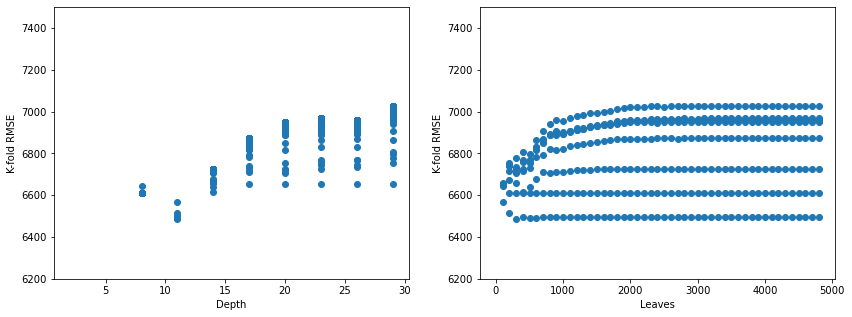

In [136]:
fig, axes = plt.subplots(1,2,figsize=(14,5))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(cv_results.param_max_depth, np.sqrt(-cv_results.mean_test_neg_mean_squared_error), 'o')
axes[0].set_ylim([6200, 7500])
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('K-fold RMSE')
axes[1].plot(cv_results.param_max_leaf_nodes, np.sqrt(-cv_results.mean_test_neg_mean_squared_error), 'o')
axes[1].set_ylim([6200, 7500])
axes[1].set_xlabel('Leaves')
axes[1].set_ylabel('K-fold RMSE');

We observe that for a depth of around 8-14, and number of leaves within 1000, we get the lowest $K$-fold RMSE. So, we should do a finer search in that region to obtain more precise hyperparameter values.

### Cross validation: Finer grid

In [110]:
#Finding cross-validation error for trees
start_time = tm.time()
parameters = {'max_depth':range(8,15),'max_leaf_nodes':range(2,1000)}
cv = KFold(n_splits = 5,shuffle=True,random_state=1)
model = GridSearchCV(DecisionTreeRegressor(random_state=1), parameters, n_jobs=-1,verbose=1,cv=cv)
model.fit(X, y)
print (model.best_score_, model.best_params_) 
print("Time taken =", round((tm.time() - start_time)/60), "minutes")

Fitting 5 folds for each of 6986 candidates, totalling 34930 fits
0.8465176078797111 {'max_depth': 10, 'max_leaf_nodes': 262}
Time taken = 1 minutes


From the above cross-validation, the optimal hyperparameter values are `max_depth = 10` and `max_leaf_nodes = 262`.

In [160]:
#Developing the tree based on optimal hyperparameters found by cross-validation
model = DecisionTreeRegressor(random_state=1, max_depth=10,max_leaf_nodes=262) 
model.fit(X, y)

DecisionTreeRegressor(max_depth=10, max_leaf_nodes=262, random_state=1)

In [161]:
#RMSE on test data
Xtest = test[['mileage','mpg','year','engineSize']]
np.sqrt(mean_squared_error(test.price, model.predict(Xtest)))

6921.0404660552895

The RMSE for the decision tree is lower than that of linear regression models and spline regression models (including MARS), with these four predictors. This may be probably due to car price having a highly non-linear association with the predictors.

**Predictor importance:** The importance of a predictor is computed as the (normalized) total reduction of the criterion (SSE in case of regression trees) brought by that predictor. 

Warning: impurity-based feature importances can be misleading for high cardinality features (many unique values)
*Source: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.feature_importances_* 

**Why?**

Because high cardinality predictors will tend to overfit. When the predictors have high cardinality, it means they form little groups *(in the leaf nodes)* and then the model "learns" the individuals, instead of "learning" the general trend. The higher the cardinality of the predictor, the more prone is the model to overfitting.

In [162]:
model.feature_importances_

array([0.04490344, 0.15882336, 0.29739951, 0.49887369])

*Engine size* is the most important predictor, followed by *year*, which is followed by *mpg*, and *mileage* is the least important predictor.

## Cost complexity pruning

While optimizing parameters above, we optimized them within a range that we thought was reasonable. While doing so, we restricted ourselves to considering only a subset of the unpruned tree. Thus, we could have missed out on finding the optimal tree (or the best model).

With cost complexity pruning, we first develop an unpruned tree without any restrictions. Then, using cross validation, we find the optimal value of the tuning parameter $\alpha$. All the non-terminal nodes for which $\alpha_{eff}$ is smaller that the optimal $\alpha$ will be pruned. You will need to check out the link below to understand this better.

Check out a detailed explanation of how cost complexity pruning is implemented in sklearn at: https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning

Here are some informative visualizations that will help you understand what is happening in cost complexity pruning: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py

In [163]:
model = DecisionTreeRegressor(random_state = 1)#model without any restrictions
path= model.cost_complexity_pruning_path(X,y)# Compute the pruning path during Minimal Cost-Complexity Pruning.

In [164]:
alphas=path['ccp_alphas']

In [165]:
len(alphas)

4126

In [171]:
start_time = time.time()
cv = KFold(n_splits = 5,shuffle=True,random_state=1)
tree = GridSearchCV(DecisionTreeRegressor(random_state=1), param_grid = {'ccp_alpha':alphas}, 
                     scoring = 'neg_mean_squared_error',n_jobs=-1,verbose=1,cv=cv)
tree.fit(X, y)
print (tree.best_score_, tree.best_params_)
print("Time taken =",round((time.time()-start_time)/60), "minutes")

Fitting 5 folds for each of 4126 candidates, totalling 20630 fits
-44150619.209031895 {'ccp_alpha': 143722.94076639024}
Time taken = 11 minutes


The code took 2 minutes to run on a dataset of about 5000 observations and 4 predictors.

In [168]:
model = DecisionTreeRegressor(ccp_alpha=143722.94076639024,random_state=1)
model.fit(X, y)
pred = model.predict(Xtest)
np.sqrt(mean_squared_error(test.price, pred))

7306.592294294368

The RMSE for the decision tree with cost complexity pruning is lower than that of linear regression models and spline regression models (including MARS), with these four predictors. However, it is higher than the one obtained with tuning tree parameters using grid search (shown previously). Cost complexity pruning considers a completely unpruned tree unlike the 'grid search' method of searching over a grid of hyperparameters such as `max_depth` and `max_leaf_nodes`, and thus may seem to be more comprehensive than the 'grid search' approach. However, both the approaches may consider trees that are not considered by the other approach, and thus either one may provide a more accurate model. Depending on the grid of parameters chosen for cross validation, the grid search method may be more or less comprehensive than cost complexity pruning.

In [172]:
gridcv_results = pd.DataFrame(tree.cv_results_)
cv_error = -gridcv_results['mean_test_score']

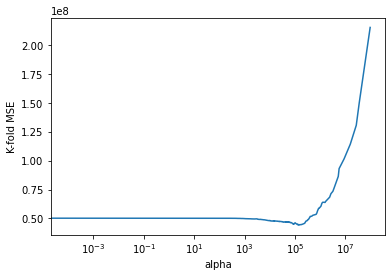

In [182]:
#Visualizing the 5-fold cross validation error vs alpha
plt.plot(alphas,cv_error)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('K-fold MSE');

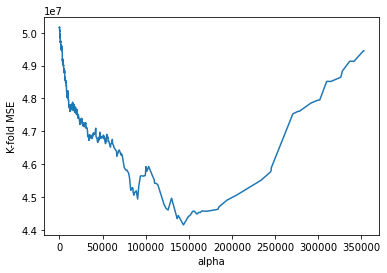

In [183]:
#Zooming in the above visualization to see the alpha where the 5-fold cross validation error is minimizing
plt.plot(alphas[0:4093],cv_error[0:4093])
plt.xlabel('alpha')
plt.ylabel('K-fold MSE');

### Depth vs alpha; Node counts vs alpha

In [80]:
stime = time.time()
trees=[]
for i in alphas:
    tree = DecisionTreeRegressor(ccp_alpha=i,random_state=1)
    tree.fit(X, train['price'])
    trees.append(tree)
print(time.time()-stime)

268.10325384140015


This code takes 4.5 minutes to run

In [82]:
node_counts = [clf.tree_.node_count for clf in trees]
depth = [clf.tree_.max_depth for clf in trees]

Text(0.5, 1.0, 'Depth vs alpha')

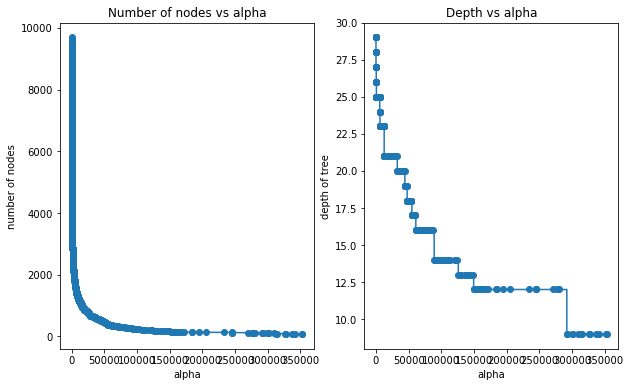

In [83]:
fig, ax = plt.subplots(1, 2,figsize=(10,6))
ax[0].plot(alphas[0:4093], node_counts[0:4093], marker="o", drawstyle="steps-post")#Plotting the zoomed-in plot (ignoring very high alphas), otherwise it is hard to see the trend
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(alphas[0:4093], depth[0:4093], marker="o", drawstyle="steps-post")#Plotting the zoomed-in plot (ignoring very high alphas), otherwise it is hard to see the trend
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
#fig.tight_layout()

### Train and test accuracies (R-squared) vs alpha

In [ ]:
train_scores = [clf.score(X, y) for clf in trees]
test_scores = [clf.score(Xtest, test.price) for clf in trees]

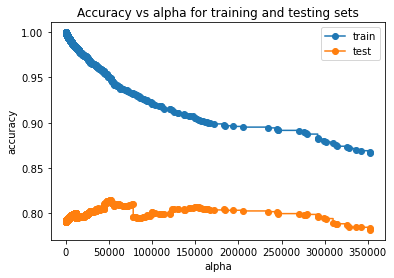

In [85]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(alphas[0:4093], train_scores[0:4093], marker="o", label="train", drawstyle="steps-post")#Plotting the zoomed-in plot (ignoring very high alphas), otherwise it is hard to see the trend
ax.plot(alphas[0:4093], test_scores[0:4093], marker="o", label="test", drawstyle="steps-post")#Plotting the zoomed-in plot (ignoring very high alphas), otherwise it is hard to see the trend
ax.legend()
plt.show()